In [33]:
! pip install lib

# Latent ODEs for Irregularly-Sampled Time Series

In [376]:
###########################
# Latent ODEs for Irregularly-Sampled Time Series
# Author: Yulia Rubanova
###########################

# Create a synthetic dataset
from __future__ import absolute_import, division
from __future__ import print_function
import os
import matplotlib
if os.path.exists("/Users/yulia"):
	matplotlib.use('TkAgg')
else:
	matplotlib.use('Agg')

import numpy as np
import numpy.random as npr
from scipy.special import expit as sigmoid
import pickle
import matplotlib.pyplot as plt
import matplotlib.image
import torch

# ======================================================================================

def get_next_val(init, t, tmin, tmax, final = None):
	if final is None:
		return init
	val = init + (final - init) / (tmax - tmin) * t
	return val


def generate_periodic(time_steps, init_freq, init_amplitude, starting_point, 
	final_freq = None, final_amplitude = None, phi_offset = 0.):

	tmin = time_steps.min()
	tmax = time_steps.max()

	data = []
	t_prev = time_steps[0]
	phi = phi_offset
	for t in time_steps:
		dt = t - t_prev
		amp = get_next_val(init_amplitude, t, tmin, tmax, final_amplitude)
		freq = get_next_val(init_freq, t, tmin, tmax, final_freq)
		phi = phi + 2 * np.pi * freq * dt # integrate to get phase

		y = amp * np.sin(phi) + starting_point
		t_prev = t
		data.append([t,y])
	return np.array(data)

def assign_value_or_sample(value, sampling_interval = [0.,1.]):
	if value is None:
		int_length = sampling_interval[1] - sampling_interval[0]
		return np.random.random() * int_length + sampling_interval[0]
	else:
		return value

class TimeSeries:
	def __init__(self, device = torch.device("cpu")):
		self.device = device
		self.z0 = None

	def init_visualization(self):
		self.fig = plt.figure(figsize=(10, 4), facecolor='white')
		self.ax = self.fig.add_subplot(111, frameon=False)
		plt.show(block=False)

	def visualize(self, truth):
		self.ax.plot(truth[:,0], truth[:,1])

	def add_noise(self, traj_list, time_steps, noise_weight):
		n_samples = traj_list.size(0)

		# Add noise to all the points except the first point
		n_tp = len(time_steps) - 1
		noise = np.random.sample((n_samples, n_tp))
		noise = torch.Tensor(noise).to(self.device)

		traj_list_w_noise = traj_list.clone()
		# Dimension [:,:,0] is a time dimension -- do not add noise to that
		traj_list_w_noise[:,1:,0] += noise_weight * noise
		return traj_list_w_noise



class Periodic_1d(TimeSeries):
	def __init__(self, device = torch.device("cpu"), 
		init_freq = 0.3, init_amplitude = 1.,
		final_amplitude = 10., final_freq = 1., 
		z0 = 0.):
		"""
		If some of the parameters (init_freq, init_amplitude, final_amplitude, final_freq) is not provided, it is randomly sampled.
		For now, all the time series share the time points and the starting point.
		"""
		super(Periodic_1d, self).__init__(device)
		
		self.init_freq = init_freq
		self.init_amplitude = init_amplitude
		self.final_amplitude = final_amplitude
		self.final_freq = final_freq
		self.z0 = z0

	def sample_traj(self, time_steps, n_samples = 1, noise_weight = 1.,
		cut_out_section = None):
		"""
		Sample periodic functions. 
		"""
		traj_list = []
		for i in range(n_samples):
			init_freq = assign_value_or_sample(self.init_freq, [0.4,0.8])
			if self.final_freq is None:
				final_freq = init_freq
			else:
				final_freq = assign_value_or_sample(self.final_freq, [0.4,0.8])
			init_amplitude = assign_value_or_sample(self.init_amplitude, [0.,1.])
			final_amplitude = assign_value_or_sample(self.final_amplitude, [0.,1.])

			noisy_z0 = self.z0 + np.random.normal(loc=0., scale=0.1)

			traj = generate_periodic(time_steps, init_freq = init_freq, 
				init_amplitude = init_amplitude, starting_point = noisy_z0, 
				final_amplitude = final_amplitude, final_freq = final_freq)

			# Cut the time dimension
			traj = np.expand_dims(traj[:,1:], 0)
			traj_list.append(traj)

		# shape: [n_samples, n_timesteps, 2]
		# traj_list[:,:,0] -- time stamps
		# traj_list[:,:,1] -- values at the time stamps
		traj_list = np.array(traj_list)
		traj_list = torch.Tensor().new_tensor(traj_list, device = self.device)
		traj_list = traj_list.squeeze(1)

		traj_list = self.add_noise(traj_list, time_steps, noise_weight)
		return traj_list

In [377]:
from torch.distributions import uniform
import torch

max_t_extrap = 5.0
n_total_tp = 100

distribution = uniform.Uniform(torch.Tensor([0.0]),torch.Tensor([max_t_extrap]))
time_steps_extrap =  distribution.sample(torch.Size([n_total_tp-1]))[:,0]
time_steps_extrap = torch.cat((torch.Tensor([0.0]), time_steps_extrap))
time_steps_extrap = torch.sort(time_steps_extrap)[0]

dataset_obj = None
##################################################################
# Sample a periodic function
dataset_obj = Periodic_1d(
    init_freq = None, init_amplitude = 1.,
    final_amplitude = 1., final_freq = None, 
    z0 = 1.)

n = 3
noise_weight = 0.5
dataset = dataset_obj.sample_traj(time_steps_extrap, n_samples = n, 
    noise_weight = noise_weight)

# PyMice Amputation Class

In [380]:
"""Transformer for generating multivariate missingness in complete datasets"""
import numpy as np
from sklearn.base import TransformerMixin
from scipy import stats


class MultivariateAmputation(TransformerMixin):
    """Generating multivariate missingness patterns in complete datasets

    Some short explanation.

    Parameters
    ----------
    complete_data : matrix with shape (A, B)

    prop : float

    patterns : matrix with shape (C, B)

    freq : array of length B

    weights : matrix with shape (C, B)

    std : boolean

    mechanism: array of length B

    logit_type : array of length B

    lower_range : float

    upper_range : float

    max_dif_with_target : float

    max_iter : integer

    Attributes
    ----------
    incomplete_data : 

    Notes
    -----
    Something on difference ampute in R and Python

    References
    ----------
    .. [1] Rianne Margaretha Schouten, Peter Lugtig & Gerko Vink (2018). 
    Generating missing values for simulation purposes: A multivariate amputation procedure. 
    Journal of Statistical Computation and Simulation, DOI: 10.1080/00949655.2018.1491577
    """


    def __init__(self,
                 prop=0.5, 
                 patterns=None, 
                 freqs=None, 
                 weights=None, 
                 std=True, 
                 mechanisms=None,
                 types=None,
                 lower_range=-3,
                 upper_range=3,
                 max_dif_with_target=0.001,
                 max_iter=100):

        self.prop = prop
        self.patterns = patterns
        self.freqs = freqs
        self.weights = weights
        self.std = std
        self.mechanisms = mechanisms
        self.types = types
        self.lower_range = lower_range
        self.upper_range = upper_range
        self.max_dif_with_target = max_dif_with_target
        self.max_iter = max_iter


    def _binary_search(self, wss_standardized, i): 
  
        b = 0
        counter = 0
        lower_range = self.lower_range
        upper_range = self.upper_range

        # start binary search with a maximum amount of tries of max_iter
        while counter < self.max_iter:
            counter += 1
          
            # in every iteration, the new b is the mid of the lower and upper range
            # the lower and upper range are updated at the end of each iteration
            b = lower_range + (upper_range - lower_range)/2
            if counter == self.max_iter: break 
     
            # calculate the expected missingness proportion
            # depends on the logit type, the sum scores and b
            x = np.zeros(len(wss_standardized))
            if self.types[i] == 'RIGHT': 
                x = wss_standardized + b
            elif self.types[i] == 'LEFT':
                x = -wss_standardized + b
            elif self.types[i] == 'MID':
                x = -np.absolute(wss_standardized) + 0.75 + b
            elif self.types[i] == 'TAIL':
                x = np.absolute(wss_standardized) - 0.75 + b
            probs = 1 / (1 + np.exp(-x))
            current_prop = np.sum(probs) / len(x)

            # if the expected proportion is close to the target, break
            # the maximum difference can be specified
            # if max_dif_with_target is 0.001, the proportion differs with max 0.1%
            if np.absolute(current_prop - self.prop) < self.max_dif_with_target: break

            # if we have not reached the desired proportion
            # we adjust either the upper or lower range
            # this way of adjusting works for self.types[i] = 'RIGHT'
            # need to check for the other types
            # in the next iteration, a new b is then calculated and used
            if (current_prop - self.prop) > 0: 
               upper_range = b
            else:
               lower_range = b 

        return b    


    def _choose_probabilities(self, wss, i):

        # when wss contains merely zeroos, the mechanism is MCAR
        # then each case has an equal probability of becoming missing
        if  np.all(wss == 0):
            probs = np.repeat(self.freqs[i], len(wss))
        # else we calculate the probabilities based on the wss
        else:
            # standardize wss
            wss_standardized = stats.zscore(wss)

            # calculate the size of b for the desired missingness proportion
            b = self._binary_search(wss_standardized, i)
            # apply the right logistic function
            x = np.zeros(len(wss))
            if self.types[i] == 'RIGHT':
                 x = wss_standardized + b
            elif self.types[i] == 'LEFT':
                x = -wss_standardized + b
            elif self.types[i] == 'MID':
                x = -np.absolute(wss_standardized) + 0.75 + b
            elif self.types[i] == 'TAIL':
                x = np.absolute(wss_standardized) - 0.75 + b
            # calculate probability to be missing 
            probs_matrix = 1 / (1 + np.exp(-x))
            probs = np.squeeze(np.asarray(probs_matrix))
        
        return probs


    def _calculate_sumscores(self, data_group, i):

        # transform categorical data to numerical data
        # standardize data or not
        if self.std:
            data_group = stats.zscore(data_group)
        
        # calculate sum scores
        # in case of MCAR, weights[i, ] contains merely zeroos and wss are merely zeroos
        # in case of MAR, MNAR, the mechanisms is determined by the weights
        wss = np.dot(data_group, self.weights[i, ].T)

        return wss


    def _validate_input(self, X):

        # default patterns is missingness on each variable
        if self.patterns is None:
            self.patterns = 1 - np.identity(n=X.shape[1])
        #else: 
            #check if self.patterns.shape[1] = X.shape[1]
            #check if self.patterns does not contain values other than 0 and 1
            #check if there are no patterns with merely 0 and merely 1

        # default freqs is every pattern occurs with the same frequency
        if self.freqs is None:
            self.freqs = np.repeat(1 / self.patterns.shape[0], self.patterns.shape[0])
        #else: 
            #check if freq has length equal to self.patterns.shape[0]  
            #check if freq does not have values < 0 or > 1

        # default mechanisms is MAR mechanism for each pattern 
        if self.mechanisms is None:
            self.mechanisms = np.repeat('MAR', len(self.freqs))
        elif len(self.mechanisms) == 1:
            self.mechanisms = np.repeat(self.mechanisms[0], len(self.freqs))
        #else: 
            #check if mechanism has length equal to self.patterns.shape[0]     
            #check if mechanism has no other values than 'MAR', 'MNAR' or MCAR   

        # default in case of MAR: all observed variables have weight 1
        # default in case of MNAR: all non observed variables have weight 1
        # with MCAR: all variables should have weight 0
        if self.weights is None:
            self.weights = np.zeros(shape=self.patterns.shape)
            self.weights[self.mechanisms == 'MAR', ] = self.patterns[self.mechanisms == 'MAR', ]
            self.weights[self.mechanisms == 'MNAR', ] = 1 - self.patterns[self.mechanisms == 'MNAR', ]
        #else:
            #check if self.weights.shape equals self.patterns.shape
            #check if the patterns with MCAR contain merely zeroos

        if self.types is None: 
            self.types = np.repeat('RIGHT', len(self.mechanisms))
        #else:
            # check if len equals len mechanisms and len freqs
            # check if types contains no other words then right, left, mid and tail

        return X

        
    def fit_transform(self, X):
        """Fits amputer on complete data X and returns the incomplete data X
    
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Complete input data, where "n_samples" is the number of samples and
            "n_features" is the number of features.

        Returns
        -------
        X_incomplete : array-like, shape (n_samples, n_features)
        """

        # some check functions
        # including specification of defaults
        X = self._validate_input(X)

        # split complete_data in groups
        # the number of groups is defined by the number of patterns
        # we know the number of patterns by the number of rows of self.patterns
        X_incomplete = np.zeros(X.shape)
        X_indices = np.arange(X.shape[0])
        assigned_group_number = np.random.choice(a=self.patterns.shape[0],
                                                 size=X.shape[0], p=self.freqs)
        
        # start a loop over each pattern
        for i in range(self.patterns.shape[0]):
            # assign cases to the group
            group_indices = X_indices[assigned_group_number == i]
            pattern = np.squeeze(np.asarray(self.patterns[i, ]))
            data_group = X[group_indices]
            # calculate weighted sum scores for each group
            wss = self._calculate_sumscores(data_group, i)
            # define candidate probabilities in group
            probs = self._choose_probabilities(wss, i)
            # apply probabilities and choose cases
            chosen_candidates = np.random.binomial(n=1,
                                                   size=data_group.shape[0],
                                                   p=probs)
            # apply missing data pattern
            chosen_indices = group_indices[chosen_candidates==1]
            X_incomplete[chosen_indices, pattern == 0] = np.nan

        return X_incomplete

# Wrapper Functions

In [434]:
def MNAR_masks(X, logistic_dist_type = 'MID', prop_of_missingness = 0.5,
               missingness_patterns = None, pattern_freqs = None, 
               pattern_weights = None):
    '''
    Args:
        X: Data (shape: n_samples by n_dimensions)

        logistic_dist_type: List of strings ('RIGHT', 'MID', 'TAIL' or 'LEFT' logistic distribution function)
            - If a right-tailed (RIGHT) type of missingness is used, candidates 
            with high weighted sum scores will receive a high probability of being missing 
            - With a left-tailed (LEFT), centred (MID) or both-tailed (TAIL) missingness type, 
            higher probability values are given to the candidates with low, average 
            or extreme weighted sum scores respectively

        prop_of_missingness: A scalar specifying the proportion of missingness (should be a value between 0 and 1)

        missingness_patterns: Candidate data patterns (shape: n_patterns by n_dimensions)

        pattern_freqs: Frequency of each pattern (shape: n_patterns)

        pattern_weights: Array of weights for each pattern (shape: n_patterns by n_dimensions)

       
    Original paper: https://www.tandfonline.com/doi/full/10.1080/00949655.2018.1491577

    Returns: 
        missing_data_mask: Multiply with X to mask missing data 
        non_missing_data_mask: Multiply with X to mask non-missing data (i.e. to only show values to predict)
    '''
    n_samples = X.shape[0]
    n_dimensions = X.shape[1]
    
    if missingness_pattern is None:
        n_patterns = n_dimensions
        # one column is missing in each pattern
        missingness_patterns = 1 - np.identity(n=n_dimensions)

        # assign equal frequency to each pattern
        pattern_freqs = np.array([1/n_patterns] * n_patterns)

        # assign weights k by m matrix where k is the number of patterns and m is the number of dims
        # use a standard multivariate normal distribution to sample random weights
        pattern_weights = np.random.normal(0, 1, size=(n_patterns, n_dimensions))

    # each dimension can have a different amputation distributions, let's keep them all the same for now 
    current_mechanisms = np.repeat('MNAR', n_dimensions)
    logistic_dist_types = np.repeat(logistic_dist_type, n_dimensions)

    # amputate
    ma = MultivariateAmputation(
        prop = prop_of_missingness,
        patterns=missingness_patterns, 
        freqs=pattern_freqs, 
        weights=pattern_weights, 
        mechanisms=current_mechanisms,  
        types=logistic_dist_types,
    )

    incomplete_data = ma.fit_transform(X)

    # mask the missing data
    missing_data_mask = incomplete_data.copy()
    missing_data_mask[missing_data_mask == 0] = 1

    # mask the nonmissing data
    non_missing_data_mask = incomplete_data.copy()
    non_missing_data_mask[np.isnan(non_missing_data_mask)] = 1
    non_missing_data_mask[non_missing_data_mask == 0] = np.nan

    return missing_data_mask, non_missing_data_mask

def MCAR_masks(X, prop_of_missingness = 0.5):
    '''
    Args:
        X: Data (shape: n_samples by n_dimensions)
        prop_of_missingness: A scalar specifying the proportion of missingness (should be a value between 0 and 1)
       
    Original paper: https://www.tandfonline.com/doi/full/10.1080/00949655.2018.1491577

    Returns: 
        missing_data_mask: Multiply with X to mask missing data 
        non_missing_data_mask: Multiply with X to mask non-missing data (i.e. to only show values to predict)
    '''
    n_dimensions = X.shape[1]

    # each dimension can have a different amputation distributions, let's keep them all the same for now 
    current_mechanisms = np.repeat('MCAR', n_dimensions)

    # amputate
    ma = MultivariateAmputation(
        prop = prop_of_missingness,
        mechanisms=current_mechanisms
    )

    incomplete_data = ma.fit_transform(X)

    # mask the missing data
    missing_data_mask = incomplete_data.copy()
    missing_data_mask[missing_data_mask == 0] = 1

    # mask the nonmissing data
    non_missing_data_mask = incomplete_data.copy()
    non_missing_data_mask[np.isnan(non_missing_data_mask)] = 1
    non_missing_data_mask[non_missing_data_mask == 0] = np.nan

    return missing_data_mask, non_missing_data_mask

# Example Use Case

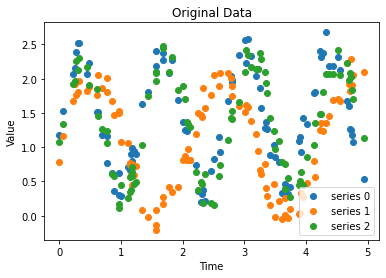

In [415]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
plt.title('Original Data')
plt.xlabel('Time')
plt.ylabel('Value')

for i, series in enumerate(dataset):
    plt.scatter(time_steps_extrap, series[:, 0], label=f"series {i}" )

plt.legend()


In [401]:
# first transpose data such that it is n_samples by n_dimensions
X = torch.transpose(dataset[:, :, 0], 0, 1)

In [435]:
n_dimensions = X.shape[1]
n_patterns = n_dimensions 

# one column is missing in each pattern
missingness_patterns = 1 - np.identity(n=n_dimensions)

# assign equal frequency to each pattern
pattern_freqs = np.array([1/n_patterns] * n_patterns)

# assign weights k by m matrix where k is the number of patterns and m is the number of dims
# use a standard multivariate normal distribution to sample random weights
pattern_weights = np.random.normal(0, 1, size=(n_patterns, n_dimensions))

missing_data_mask, non_missing_data_mask = MNAR_masks(X, 
                                                      logistic_dist_type = 'RIGHT', 
                                                      prop_of_missingness = 0.5, 
                                                      missingness_patterns = missingness_patterns, 
                                                      pattern_freqs = pattern_freqs, 
                                                      pattern_weights = pattern_weights
                                                      )

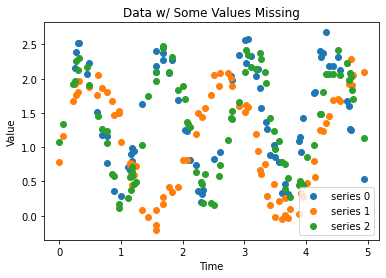

In [436]:
fig = plt.figure()
plt.title('Data w/ Some Values Missing')
plt.xlabel('Time')
plt.ylabel('Value')

for i, series in enumerate(dataset):
    plt.scatter(time_steps_extrap*missing_data_mask[:, i], series[:, 0]*missing_data_mask[:, i], label=f"series {i}" )

plt.legend()

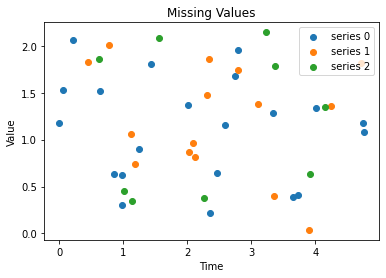

In [437]:
fig = plt.figure()
plt.title('Missing Values')
plt.xlabel('Time')
plt.ylabel('Value')

for i, series in enumerate(dataset):
    plt.scatter(time_steps_extrap*non_missing_data_mask[:, i], series[:, 0]*non_missing_data_mask[:, i], label=f"series {i}" )

plt.legend()